## Train, evaluate ssd on uadetrac and see how it performs in terms of precision and recall (unlabeled boxes)

In [6]:
## first let's load the data and corresponding boxes / labels for training

%pylab inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.argv=['']
sys.path.append('../../')


import numpy as np
import utils.helpers as helpers
import eva_storage.evaluation.evaluate_ssd as evaluate_ssd
from loaders.uadetrac_loader import UADetracLoader


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# load the data  
loader = UADetracLoader()
images = loader.load_cached_images()
labels = loader.load_cached_labels()
boxes = loader.load_boxes()
video_start_indices = loader.get_video_start_indices()

['.ipynb_checkpoints', 'MVI_20011.xml', 'MVI_20012.xml', 'MVI_20032.xml', 'MVI_20033.xml', 'MVI_20034.xml', 'MVI_20035.xml', 'MVI_20051.xml', 'MVI_20052.xml', 'MVI_20061.xml', 'MVI_20062.xml', 'MVI_20063.xml', 'MVI_20064.xml', 'MVI_20065.xml']
skipping .ipynb_checkpoints
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20011.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20012.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20032.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20033.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20034.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20035.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20051.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20052.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20061.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20062.xml
/home/jbang36/eva/data/ua_detrac/small-annotations/MVI_20063.xml
/home/jbang36

In [3]:
print(images.shape)

(10421, 300, 300, 3)


In [4]:
print(video_start_indices)

[ 664  936  437  784  800  800  906  694  800  800  800  800 1200]


In [8]:
## Starting modification of train_ssd.py for ua-detrac
## importing all relevant files
import argparse
import os
import logging
import sys
import itertools
import torch
import config as jaeho_config
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR


from eva_storage.external.ssd.vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from eva_storage.external.ssd.vision.ssd.ssd import MatchPriorModified
from eva_storage.external.ssd.vision.ssd.vgg_ssd import create_vgg_ssd
from eva_storage.external.ssd.vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
from eva_storage.external.ssd.vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite
from eva_storage.external.ssd.vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite
from eva_storage.external.ssd.vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite
#from eva_storage.external.ssd.vision.datasets.voc_dataset import VOCDataset
#from eva_storage.external.ssd.vision.datasets.open_images import OpenImagesDataset
from eva_storage.external.ssd.vision.nn.multibox_loss import MultiboxLoss
from eva_storage.external.ssd.vision.ssd.config import vgg_ssd_config
from eva_storage.external.ssd.vision.ssd.config import mobilenetv1_ssd_config
from eva_storage.external.ssd.vision.ssd.config import squeezenet_ssd_config
from eva_storage.external.ssd.vision.ssd.data_preprocessing import TrainAugmentation, TestTransform



DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    logging.info("Use Cuda.")



In [9]:
#dataset_path = "/home/jbang36/data/VOCdevkit/VOC2007"
#validation_path = "/home/jbang36/data/VOCdevkit/VOC2007"
base_net = os.path.join("/nethome/jbang36/eva/eva_storage/external/ssd", "models/vgg16_reducedfc.pth")
batch_size = 24
num_workers = 4
num_epochs = 200
checkpoint_folder = 'models/'
lr = 1e-3
momentum = 0.9
weight_decay =5e-4
validation_epochs = 5
debug_steps = 100

timer = Timer()

In [10]:
create_net = create_vgg_ssd
config = vgg_ssd_config

train_transform = TrainAugmentation(config.image_size, config.image_mean,  
                                    config.image_std)
target_transform = MatchPriorModified(config.priors, config.center_variance,
                                  config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, 
                               config.image_std)

    

In [11]:
os.getcwd()

'/home/jbang36/eva/eva_storage/evaluation'

In [12]:
## Load the model

num_classes = 5 # should this be 4 or 5?
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1
base_net_lr = lr
extra_layers_lr = lr


print("Base net is frozen..")
freeze_net_layers(net.base_net)
params = itertools.chain(net.source_layer_add_ons.parameters(), net.extras.parameters(),
                         net.regression_headers.parameters(), net.classification_headers.parameters())

params = [
    {'params': itertools.chain(
        net.source_layer_add_ons.parameters(),
        net.extras.parameters()
    ), 'lr': extra_layers_lr},
    {'params': itertools.chain(
        net.regression_headers.parameters(),
        net.classification_headers.parameters()
    )}
]

"""
## original set of networks
net.init_from_base_net(base_net)
## loading from pretrained model!!
#pretrained_ssd_dir = '/nethome/jbang36/eva/eva_storage/external/ssd/models/vgg16-ssd-Epoch-149-Loss-3.3744568502269505.pth'
#net.init_from_pretrained_ssd(pretrained_ssd_dir)


"""
net.init_from_base_net(base_net)
"""
## loading from pretrained model!!
##pretrained_ssd_dir = '/nethome/jbang36/eva/eva_storage/external/ssd/models/overnight/vgg16-ssd:epoch1000'
##net.init_from_pretrained_ssd(pretrained_ssd_dir)
"""

net.to(DEVICE)

print("Done loading to GPU")


Base net is frozen..
Done loading to GPU


In [13]:
## we must examine the network's parameters
## there are a lot of negative values....

min_value = 0
max_value = 0
for parameter in net.parameters():
    #print(parameter.data)
    print("------------------------")
    print(torch.min(parameter.data))
    print(torch.max(parameter.data))

------------------------
tensor(-0.6714, device='cuda:1')
tensor(0.6085, device='cuda:1')
------------------------
tensor(-0.0158, device='cuda:1')
tensor(2.0640, device='cuda:1')
------------------------
tensor(-0.2156, device='cuda:1')
tensor(0.2892, device='cuda:1')
------------------------
tensor(-1.0272, device='cuda:1')
tensor(0.9052, device='cuda:1')
------------------------
tensor(-0.3359, device='cuda:1')
tensor(0.4166, device='cuda:1')
------------------------
tensor(-0.1792, device='cuda:1')
tensor(0.3655, device='cuda:1')
------------------------
tensor(-0.1819, device='cuda:1')
tensor(0.2774, device='cuda:1')
------------------------
tensor(-0.5953, device='cuda:1')
tensor(0.6338, device='cuda:1')
------------------------
tensor(-0.1831, device='cuda:1')
tensor(0.5444, device='cuda:1')
------------------------
tensor(-0.2010, device='cuda:1')
tensor(0.3495, device='cuda:1')
------------------------
tensor(-0.1771, device='cuda:1')
tensor(0.4593, device='cuda:1')
----------

In [14]:
## Load the rest (optimizer, loss function, etc)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9,
                            weight_decay=5e-4)


milestones = [int(v.strip()) for v in "80,100".split(",")]
scheduler = MultiStepLR(optimizer, milestones=milestones,
                        gamma=0.1, last_epoch=last_epoch)

In [15]:


## I don't think you need to normalize.... The network deals with transformations by itself?? - true

division_point = int(images.shape[0] * 0.8)
X_train = images[:division_point]
X_test = images[division_point:]
y_train = labels['vehicle'][:division_point]
y_test = labels['vehicle'][division_point:]
y_train_boxes = boxes[:division_point]
y_test_boxes = boxes[division_point:]


In [16]:
## We need to make val dataset...

val_division = int(0.8 * len(X_train))
X_val = X_train[val_division:]
X_train = X_train[:val_division]
y_val_boxes = y_train_boxes[val_division:]
y_train_boxes = y_train_boxes[:val_division]
y_val = y_train[val_division:]
y_train = y_train[:val_division]

In [17]:
train_dataset = evaluate_ssd.UADataset_lite(transform=train_transform, target_transform=target_transform)

train_dataset.set_x(X_train)
train_dataset.set_y(y_train)
train_dataset.set_y_boxes(y_train_boxes)


0


In [18]:
val_dataset = evaluate_ssd.UADataset_lite(transform=train_transform, target_transform=target_transform)
val_dataset.set_x(X_val)
val_dataset.set_y(y_val)
val_dataset.set_y_boxes(y_val_boxes)

test_dataset = evaluate_ssd.UADataset_lite(transform=train_transform, target_transform=target_transform)
test_dataset.set_x(X_test)
test_dataset.set_y(y_test)
test_dataset.set_y_boxes(y_test_boxes)

0
0


In [19]:
## convert to loader 
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size,
                          num_workers= 4,
                          shuffle=True)

val_loader = DataLoader(val_dataset, batch_size,
                          num_workers= 4,
                          shuffle=True)

In [22]:
## as we can see here, the original corner box coordinates are converted to locations -> helps with training


for i, data in enumerate(train_loader):
    image, boxes, labels = data
    print(boxes[0][:100])
    print(labels[0][:100])
    print(boxes[0].size())
    break
    

tensor([[0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.3469, 0.0407, 0.0544, 0.0622],
        [0.2313, 0.0861, 0.0680, 0.0766],
        [0.2313, 0.0861, 0.0680, 0.0766],
        [0.3469, 0.0407, 0.0544, 0

In [23]:
## defining train / test functions

def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, gt_locations, labels = data
        images = images.to(device)
        gt_locations = gt_locations.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        ## need to make sure criterion takes in locations
        regression_loss, classification_loss = criterion(confidence, locations, labels, gt_locations)
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps
            logging.info(
                f"Epoch: {epoch}, Step: {i}, " +
                f"Average Loss: {avg_loss:.4f}, " +
                f"Average Regression Loss {avg_reg_loss:.4f}, " +
                f"Average Classification Loss: {avg_clf_loss:.4f}"
            )
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0


def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num


In [14]:
## train the model
## let's just import utils and do all evaluations here?
import time

st = time.time()

for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)

    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        running_loss = 0.0
        running_regression_loss = 0.0
        running_classification_loss = 0.0
        num = 0
        for _, data in enumerate(val_loader):
            images, boxes, labels = data
            images = images.to(DEVICE)
            boxes = boxes.to(DEVICE)
            labels = labels.to(DEVICE)
            num += 1
            with torch.no_grad():
                confidence, locations = net(images)
                regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
                loss = regression_loss + classification_loss
            running_loss += loss.item()
            running_regression_loss += regression_loss.item()
            running_classification_loss += classification_loss.item()
        val_loss = running_loss / num
        val_regression_loss = running_regression_loss / num
        val_classification_loss = running_regression_loss / num
        print("epoch", epoch)
        print("  Validation Loss: {v:.4f}".format(v=val_loss))
        print("  Validation Regression Loss: {v:.4f}".format(v=val_regression_loss))
        print("  Validation Classification Loss: {v:.4f}".format(v=val_classification_loss))
        
        checkpoint_folder = '/nethome/jbang36/eva/eva_storage/external/ssd/models'
        checkpoint_file_name = "vgg16-ssd:epoch" + str(epoch)
        model_path = os.path.join(checkpoint_folder, checkpoint_file_name)
        net.save(model_path)
        
print("Total time to train...", time.time() - st, "seconds")


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0
  Validation Loss: 3.7317
  Validation Regression Loss: 0.3286
  Validation Classification Loss: 0.3286
epoch 5
  Validation Loss: 2.8895
  Validation Regression Loss: 0.1054
  Validation Classification Loss: 0.1054
epoch 10
  Validation Loss: 2.7557
  Validation Regression Loss: 0.0726
  Validation Classification Loss: 0.0726
epoch 15
  Validation Loss: 2.7317
  Validation Regression Loss: 0.0606
  Validation Classification Loss: 0.0606
epoch 20
  Validation Loss: 2.6742
  Validation Regression Loss: 0.0503
  Validation Classification Loss: 0.0503
epoch 25
  Validation Loss: 2.6659
  Validation Regression Loss: 0.0472
  Validation Classification Loss: 0.0472
epoch 30
  Validation Loss: 2.6215
  Validation Regression Loss: 0.0415
  Validation Classification Loss: 0.0415
epoch 35
  Validation Loss: 2.6185
  Validation Regression Loss: 0.0403
  Validation Classification Loss: 0.0403
epoch 40
  Validation Loss: 2.6193
  Validation Regression Loss: 0.0390
  Validation Classificatio

KeyboardInterrupt: 

In [24]:
test_loader = DataLoader(test_dataset, batch_size,
                          num_workers= 4,
                          shuffle=False)


In [25]:
for i, data in enumerate(test_loader):
    images, boxes, labels = data
    print(boxes[0])
    break

tensor([[0.7245, 0.6651, 0.5510, 0.6699],
        [0.7245, 0.6651, 0.5510, 0.6699],
        [0.7245, 0.6651, 0.5510, 0.6699],
        ...,
        [0.7245, 0.6651, 0.5510, 0.6699],
        [0.7245, 0.6651, 0.5510, 0.6699],
        [0.7245, 0.6651, 0.5510, 0.6699]])


In [26]:
## looking at the images, I don't think this is a good measure 
## because it creates multiple boxes for each object...
## so we need to figure out a way to eliminate recurring boxes
# let's try evaluation method that is already implemented from eval_ssd.py

import eva_storage.external.ssd.eval_ssd as eval_ssd
from eva_storage.external.ssd.vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor


timer = Timer()
class_names = ['BACKGROUND', 'car', 'bus', 'others', 'van']


#true_case_stat, all_gb_boxes, all_difficult_cases = eval_ssd.group_annotation_by_class(test_loader)
true_case_stat, all_gb_boxes, all_difficult_cases = eval_ssd.group_annotation_by_class(test_dataset)
    
predictor = create_vgg_ssd_predictor(net, nms_method="hard", device=DEVICE)
results = []

dataset = test_dataset


../../eva_storage/external/ssd/eval_ssd.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])


In [27]:
## all_gb_boxes.keys() == [1,2,3,4]
## for each all_gb_box[key] it is dict{frame_id: box_coordinates}


(all_gb_boxes.keys())
all_gb_boxes[1][1]

tensor([[213.,   0., 220.,  11.],
        [199.,   6., 205.,  17.],
        [203.,   0., 208.,  13.],
        [209.,  10., 217.,  24.],
        [222.,  18., 232.,  34.],
        [218.,  22., 230.,  40.],
        [166.,  15., 174.,  28.],
        [179.,   6., 185.,  18.],
        [263.,  30., 290.,  51.],
        [263.,  63., 287., 100.]])

In [28]:
for i in range(len(dataset)):
    print("process image", i)
    timer.start("Load Image")
    image = dataset.get_image(i)
    print("Load Image: {:4f} seconds.".format(timer.end("Load Image")))
    timer.start("Predict")
    boxes, labels, probs = predictor.predict(image)
    print("Prediction: {:4f} seconds.".format(timer.end("Predict")))
    indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
    results.append(torch.cat([
        indexes.reshape(-1, 1),
        labels.reshape(-1, 1).float(),
        probs.reshape(-1, 1),
        boxes   # + 1.0 matlab's indexes start from 1
    ], dim=1))
    
    
results = torch.cat(results)

process image 0
Load Image: 0.003143 seconds.
Inference time:  2.7015533447265625
Prediction: 2.945916 seconds.
process image 1
Load Image: 0.000012 seconds.
Inference time:  0.006108283996582031
Prediction: 0.216254 seconds.
process image 2
Load Image: 0.000014 seconds.
Inference time:  0.004911184310913086
Prediction: 0.261668 seconds.
process image 3
Load Image: 0.000016 seconds.
Inference time:  0.0053212642669677734
Prediction: 0.246167 seconds.
process image 4
Load Image: 0.000014 seconds.
Inference time:  0.006210803985595703
Prediction: 0.255522 seconds.
process image 5
Load Image: 0.000015 seconds.
Inference time:  0.006213188171386719
Prediction: 0.350496 seconds.
process image 6
Load Image: 0.000016 seconds.
Inference time:  0.006197690963745117
Prediction: 0.261239 seconds.
process image 7
Load Image: 0.000012 seconds.
Inference time:  0.005008220672607422
Prediction: 0.213735 seconds.
process image 8
Load Image: 0.000012 seconds.
Inference time:  0.004869699478149414
Predi

In [29]:
prediction_results = results

In [30]:
## it would be best to save the results....
# result would be a list of tensors...how are we going to save this?
print(results.size(0))
print(results[10000]) ##index, label, probs, boxes - so there should be 7
print(results[100000:110000])

2026577
tensor([  10.0000,    1.0000,    2.1763, -201.0100,   17.0225,   35.8360,
         -48.6696])
tensor([[ 102.0000,    4.0000,    1.8368,  ...,  452.3837,  267.5796,
          276.0197],
        [ 102.0000,    4.0000,    1.8356,  ..., -237.5963, -404.1473,
         -149.7341],
        [ 102.0000,    4.0000,    1.8343,  ...,  -83.9574, -157.7726,
          272.7111],
        ...,
        [ 113.0000,    0.0000,    1.5800,  ..., -410.6375,  -90.0592,
         -119.0215],
        [ 113.0000,    0.0000,    1.5743,  ..., -136.0241, -280.5690,
         -124.4400],
        [ 113.0000,    0.0000,    1.5743,  ...,   -8.8527, -283.4821,
          -58.3186]])


In [ ]:
## These boxes should be in corner format??? Need to look into that.... also, need to look into the parameters....



In [43]:
true_case_stat, all_gb_boxes, all_difficult_cases = eval_ssd.group_annotation_by_class(dataset)

In [45]:
a = all_gb_boxes[1][2084]
print(a.size())
for t in a:
    print(t)

torch.Size([3, 4])
tensor([132.,  43., 149.,  68.])
tensor([144.,  52., 161.,  79.])
tensor([171.,   6., 180.,  20.])


In [25]:
## need to convert the ground truth boxes (corner form) to center form
from eva_storage.external.ssd.vision.utils import box_utils

new_all_gb_boxes = {}
for key in all_gb_boxes.keys():
    new_all_gb_boxes[key] = {}
    for frame_key in all_gb_boxes[key].keys():
        boxes_tensor = all_gb_boxes[key][frame_key] ## boxes_tensor are in corner form
        boxes_center_tensor = box_utils.corner_form_to_center_form(boxes_tensor)
        
        new_all_gb_boxes[key][frame_key] = boxes_center_tensor
## all boxes converted to center format


In [46]:
class_names = ['BACKGROUND', 'car', 'bus', 'others', 'van']
eval_path = '/nethome/jbang36/eva/eva_storage/evaluation'

for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue  # ignore background
    prediction_path = os.path.join(eval_path,f"det_test_{class_name}.txt")
    with open(prediction_path, "w") as f:
        sub = results[results[:, 1] == class_index, :]
        for i in range(sub.size(0)):
            prob_box = sub[i, 2:].numpy()
            image_id = int(sub[i,0])
            print(
                str(image_id) + " " + " ".join([str(v) for v in prob_box]),
                file=f
            )



In [37]:
a = torch.Tensor([1,1,5,6])
b = box_utils.corner_form_to_center_form(a)
c = box_utils.center_form_to_corner_form(b)
print( b )
print( c )

tensor([3.0000, 3.5000, 4.0000, 5.0000])
tensor([1., 1., 5., 6.])


In [47]:

aps = []
    
iou_threshold = 0.5
use_2007_metric = True
print("\n\nAverage Precision Per-class:")


for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue #background
    prediction_path = os.path.join(eval_path, f"det_test_{class_name}.txt")

    print(class_index, class_name)
    ap = eval_ssd.compute_average_precision_per_class_modified(
        true_case_stat[class_index],
        all_gb_boxes[class_index],
        all_difficult_cases[class_index],
        prediction_path,
        iou_threshold, 
        use_2007_metric
    )
    aps.append(ap)
    break
    
print("------------")
print(aps)
print(sum(aps))
print(len(aps))
print("------------")

    
print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")



Average Precision Per-class:
1 car
410225
<class 'list'>
hello world
<class 'numpy.ndarray'>
410225
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
Printing stats for class...
true_positive [0. 0. 0. ... 5. 5. 5.]
false_positive [1.00000e+00 2.00000e+00 3.00000e+00 ... 4.10218e+05 4.10219e+05
 4.10220e+05]
precision is [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.21884926e-05
 1.21884629e-05 1.21884332e-05]
recall is [0.         0.         0.         ... 0.00017446 0.00017446 0.00017446]
------------
[7.857990397535735e-06]
7.857990397535735e-06
1
------------

Average Precision Across All Classes:7.857990397535735e-06


In [56]:
import random
import cv2




1 car
410225
<class 'list'>


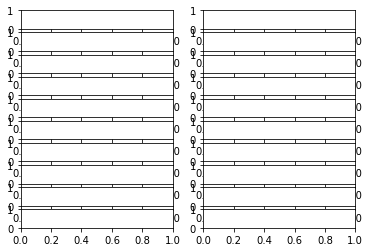

In [58]:
## TODO: we should start drawing boxes on the images to make sure everything is correct. The accuracy is too low

row = 0
fig, axes = plt.subplots(nrows = 10, ncols = 2, sharex = False, sharey = False)


for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue
    if row >= 10: break
    prediction_path = os.path.join(eval_path, f"det_test_{class_name}.txt")

    print(class_index, class_name)
    ## here we get the random indexes from images and draw those things...
    box_dict = eval_ssd.return_boxes(true_case_stat[class_index], all_gb_boxes[class_index], all_difficult_cases[class_index], prediction_path, iou_threshold, use_2007_metric)
    break
    
    

In [59]:

for i in range(10):
    random_index = random.randint(0, 2084)
    image = test_dataset.get_image(random_index)

    image_w_gt = np.copy(image)
    image_w_pr = np.copy(image)
    gt_boxes = box_dict[random_index][0]
    proposed_box = box_dict[random_index][1]
    ious = box_dict[random_index][2]
    gt_boxes_np = gt_boxes.numpy()
    gt_boxes_np = gt_boxes_np.astype(np.uint8)
    
    for gt_box in gt_boxes_np:
        print(gt_box_np)
        cv2.rectangle(image_w_gt, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (0, 20, 200), 10)

    print(proposed_box)
    cv2.rectangle(image_w_pr, (proposed_box[0], proposed_box[1]), (proposed_box[2], proposed_box[3]), (0, 100, 20), 10)

    axes[row, 0].imshow(image_w_gt)
    axes[row, 1].imshow(image_w_pr)
    print(ious)
    row += 1
        

tensor([155.,  77., 172., 106.])
tensor([167.,  13., 173.,  23.])
tensor([168.,  26., 176.,  40.])
tensor([161.,  53., 175.,  76.])
tensor([195.,  71., 214., 101.])
tensor([219.,  40., 232.,  60.])
tensor([239.,  47., 255.,  69.])
tensor([223.,  30., 234.,  45.])
tensor([233.,  26., 244.,  43.])
tensor([213.,  22., 222.,  38.])
tensor([203.,  14., 210.,  26.])
tensor([209.,  12., 216.,  21.])
tensor([266.,  79., 289., 109.])
tensor([[ 833.4760, 1327.2214,  823.4850, -129.1548]])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [40]:
## this is not working out,... will be trying to do this on my own
# 1. what is results? - 
# 2. how is all_gb_boxes calculated?

print(len(results))
print(results[0])


1484562
tensor([   0.0000,    0.0000,    6.7497, -935.9111,  -73.3641, -460.0108,
         148.5687])


In [77]:
### modification of the above code so that it is label agnostic

class_names = ['car', 'bus', 'others', 'van']

for class_index, class_name in enumerate(class_names):
    if class_index == 0: continue
    sub = results[results[:, 1] == class_index, :]
    print(sub)
    break
    

tensor([[ 0.0000e+00,  1.0000e+00,  2.1856e+00,  ..., -2.6608e+02,
          2.7891e+02,  2.9862e+02],
        [ 0.0000e+00,  1.0000e+00,  2.1619e+00,  ...,  1.3276e+02,
         -8.6016e+02, -5.3174e+02],
        [ 0.0000e+00,  1.0000e+00,  1.9328e+00,  ...,  1.5986e+01,
          8.9088e+01, -3.5483e+02],
        ...,
        [ 2.0840e+03,  1.0000e+00,  6.7476e-01,  ...,  4.7634e+01,
         -5.6946e+02,  7.4701e+01],
        [ 2.0840e+03,  1.0000e+00,  6.7333e-01,  ..., -1.9436e+02,
         -7.4217e+01, -1.6923e+02],
        [ 2.0840e+03,  1.0000e+00,  6.7099e-01,  ..., -2.4908e+02,
         -2.5618e+02, -3.6421e+01]])


In [78]:
sub.size()

torch.Size([412210, 7])

In [50]:
for _, data in enumerate(test_loader):
    images, boxes, labels = data
    images = images.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        confidence, locations = net(images)
    break
    
## we now have images, boxes, labels, confidence, locations

In [53]:
type(images)
type(confidence)
type(locations)

torch.Tensor

In [54]:
confidence.size()

torch.Size([24, 8732, 4])

In [57]:
confidence[0,0]

tensor([ 6.2897, -2.7312, -0.9714, -0.9492], device='cuda:1')

In [56]:
locations.size()

torch.Size([24, 8732, 4])

In [58]:
locations[0,0]

tensor([-2.4966, -0.5008, -1.5910, -0.8949], device='cuda:1')

In [ ]:
import eva_storage.external.ssd.vision.utils as ssd_utils
## need to convert locations to boxes
# I think the center_form_to_corner_form might be wrong??


predicted_locations = locations.cpu()

predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

gt_locations = boxes.cpu() ## they have converted boxes to locations
gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)


gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)

In [ ]:
"""
For some reason I can't figure out, rectangles are not being drawn on the images
"""

n_samples = predicted_boxes.size(0)
print(n_samples)
image_size = 300
color = (255, 0,0)

rows = 5
cols = 3
amp = 1

fig, axes = plt.subplots(rows, cols, figsize = (30*amp,30*amp))


for i in range(n_samples):
    img_tmp = np.ndarray(shape = (300,300,3), dtype = np.uint8)
    image = images_cpu[i]
    predicted_boxes_reshaped = predicted_boxes[i][pos_mask[i], :]
    gt_boxes_reshaped = gt_boxes[i][pos_mask[i], :]
    
    
    image = image.permute(1,2,0)
    image_np = image.numpy().astype(np.uint8)
    image_cp = np.copy(image_np)
    
    
    axes[i,0].imshow(image_np)
    n_rects = predicted_boxes_reshaped.size(0)
    pbr = (predicted_boxes_reshaped.numpy() * image_size).astype(np.uint8)
    gbr = (gt_boxes_reshaped.numpy() * image_size).astype(np.uint8)
    for j in range(n_rects):
        #should be left, top, right, bottom
        # let's draw the ground boxes to be sure
        
        cv2.rectangle(image_np, (pbr[j][0], pbr[j][1]), (pbr[j][2], pbr[j][3]), color, 2)
            
    axes[i,1].imshow(image_np)
    
    n_rects = gt_boxes_reshaped.size(0)
    for j in range(n_rects):
        cv2.rectangle(image_cp, (gbr[j][0], gbr[j][1]), (gbr[j][2], gbr[j][3]), color, 2)
        
    
    axes[i,2].imshow(image_cp)
    
    if i == rows - 1:
        break
        

In [ ]:
## we want to do things image by image... let's organize the boxes into list
predicted_boxes_list = []
gt_boxes_list = []



pos_mask = labels > 0
predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
print(predicted_boxes_reshaped.size())
gt_boxes_reshaped = gt_boxes[pos_mask, :]
print(gt_boxes_reshaped.size())
## I guess all we need is the statistics so convert them all and then see


In [ ]:
### Evaluation

## do code evaluation...

all_ground_boxes = []
all_proposed_boxes = []
all_confidence = []
all_labels = []
all_images = []

for _, data in enumerate(test_loader):
    images, boxes, labels = data
    images = images.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        confidence, locations = net(images)
        all_proposed_boxes.append(locations)
        all_confidence.append(confidence)
        all_labels.append(labels)
        all_ground_boxes.append(boxes)
        all_images.append(images)
    


In [ ]:
# each element in this array will be the batch result

assert(len(all_proposed_boxes) == len(all_confidence))
assert(len(all_proposed_boxes) == len(all_labels))
assert(len(all_proposed_boxes) == len(all_ground_boxes))
assert(len(all_proposed_boxes) == len(all_images))

def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, proposed_boxes)
    tmp = iou_list > iou
    
    tp = torch.sum(iou_list > iou)
    
    return tp.item(), tmp.size()

import vision.utils as ssd_utils

In [ ]:
tp_all = 0
boxes_all = 0

for i, images in enumerate(all_images):
    predicted_locations = all_proposed_boxes[i].cpu()
    predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
    predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

    gt_locations = all_ground_boxes[i].cpu()
    gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
    gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)

    labels = all_labels[i]
    pos_mask = labels > 0
    predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
    gt_boxes_reshaped = gt_boxes[pos_mask, :]
    tp, all_size = compute_stats(gt_boxes_reshaped, predicted_boxes_reshaped)
    tp_all += tp
    boxes_all += all_size[0]
    
print(1.0 * tp_all / boxes_all)    

In [ ]:
# we need to accumulate the results..
# also if there are squares that are being used multiple times, we need to prevent that bc it's not fair to detect easy ones multiple times to get good numbers
# adapt this some how...
## TODO! This function is not finished...

matched = set()
for i, image_batch in enumerate(all_images):
    predicted_locations = all_proposed_boxes[i].cpu()
    predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
    predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

    gt_locations = all_ground_boxes[i].cpu()
    gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
    gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)
    labels = all_labels[i]
    
    
    for j in range(image_batch.size(0)):
        image = image_batch[j]
        labels_frame = labels[j]
        gt_boxes_frame = gt_boxes[j]
        predicted_boxes_frame = predicted_boxes[j]
        
        pos_mask = labels_frame > 0
        predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
        gt_boxes_reshaped = gt_boxes[pos_mask, :]
        tp, all_size = compute_stats(gt_boxes_reshaped, predicted_boxes_reshaped)
        tp_all += tp
        boxes_all += all_size[0]
        
for i, image_id in enumerate(image_ids):
    box = boxes[i]
    if image_id not in gt_boxes:
        false_positive[i] = 1
        continue

    gt_box = gt_boxes[image_id]
    ious = box_utils.iou_of(box, gt_box)
    max_iou = torch.max(ious).item() 
    # the only reason you can do this is if you assume there is one box per frame
    # however, uadetrac does not have one frame, it has multiple frames. 
    # we need to look into the transformer to see how everything changes
    max_arg = torch.argmax(ious).item()
    if max_iou > iou_threshold:
        if difficult_cases[image_id][max_arg] == 0:
            if (image_id, max_arg) not in matched:
                true_positive[i] = 1
                matched.add((image_id, max_arg))
            else:
                false_positive[i] = 1
    else:
        false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall)
    else:
        return measurements.compute_average_precision(precision, recall)



In [ ]:
labels = all_labels[0]
predicted_locations = all_proposed_boxes[0]
gt_locations = all_ground_boxes[0]

import vision.utils as ssd_utils
## need to convert locations to boxes

predicted_locations = all_proposed_boxes[0].cpu()
predicted_boxes = ssd_utils.box_utils.convert_locations_to_boxes(predicted_locations, config.priors, config.center_variance, config.size_variance)
predicted_boxes = ssd_utils.box_utils.center_form_to_corner_form(predicted_boxes)

gt_locations = all_ground_boxes[0].cpu()
gt_boxes = ssd_utils.box_utils.convert_locations_to_boxes(gt_locations, config.priors, config.center_variance, config.size_variance)
gt_boxes = ssd_utils.box_utils.center_form_to_corner_form(gt_boxes)


pos_mask = labels > 0
predicted_boxes_reshaped = predicted_boxes[pos_mask, :]
print(predicted_boxes_reshaped.size())
gt_boxes_reshaped = gt_boxes[pos_mask, :]
print(gt_boxes_reshaped.size())
## I guess all we need is the statistics so convert them all and then see

### okay now we have to start matching??
### -> I don't think we need to manually match
### -> Let's just calculate the final score first to see what's up

def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, predicted_boxes)
    tmp = iou_list > iou
    print(tmp)
    
    tp = torch.sum(iou_list > iou)
    return tp

print(compute_stats(gt_boxes, predicted_boxes))


In [ ]:

### okay now we have to start matching??
### -> I don't think we need to manually match
### -> Let's just calculate the final score first to see what's up

def compute_stats(gt_boxes, proposed_boxes, iou=0.5):
    assert(gt_boxes.size() == proposed_boxes.size())
    iou_list = ssd_utils.box_utils.iou_of(gt_boxes, predicted_boxes)
    tmp = iou_list > iou
    print(tmp)
    
    tp = torch.sum(iou_list > iou)
    return tp



In [ ]:
print(smooth_l1_loss)
print(num_pos)
print(predicted_locations.size())
print(gt_locations.size())

## probably make a converting function....
# proposed_boxes = convertssd2ml(all_locations)

### after training on UA-detrac, let's do some evaluation!
## Use the functions available from utils

precision, recall = corloc(test_boxes, proposed_boxes, iou = 0.5)
print(precision)
print(recall)

### after filtering
filtered_test_boxes = filter_ground_truth(test_boxes)

precision, recall = corloc(filtered_test_boxes, proposed_boxes, iou = 0.5)
print(precision)
print(recall)

### visualization

from utils import *

rows = 5
cols = 3
size = 30
n_samples = test_images.shape[0]
fig, axes = plt.subplots(rows, cols, figsize = (size*cols, size*rows), sharex = True, sharey = True)

for i in range(rows):
    random_index = random.randint(0, n_samples)
    axes[i, 0].imshow(test_images[random_index])
    cv_patches = ml2cv_patches(filtered_test_boxes[random_index])
    ground_image = draw_patches(test_images[random_index], cv_patches)
    axes[i, 1].imshow(ground_image)
    cv_patches2 = ml2cv_patches(proposed_boxes[random_index])
    proposed_image = draw_patches(test_images[random_index], cv_patches2)
    axes[i, 2].imshow(proposed_image)
    print("row", i)
    precision, recall = corloc([filtered_test_boxes[random_index]], [proposed_boxes[random_index]], iou = 0.5)
    print("  precision:", precision, " recall:", recall)
    
    